# Dutch air quality dataset - daily data

- https://aqicn.org/city/amsterdam/
- https://www.luchtmeetnet.nl/informatie/luchtkwaliteit/luchtkwaliteitsindex-(lki)

## Installing packages

In [193]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mode
import collections
from datetime import date
import scipy.stats as stats

## Importing data

In [35]:
air_quality = pd.read_csv(r'C:\Users\claud\data_final_project\Usefull\amsterdam-air-quality.csv')

In [36]:
air_quality.shape

(2666, 7)

In [4]:
air_quality.dtypes

date     object
 pm25    object
 pm10    object
 o3      object
 no2     object
 so2     object
 co      object
dtype: object

- Treating the first column as it's not formated as date

In [37]:
newdate = []

for i in air_quality['date']:
    a = i.split('/')
    year = "{:04d}".format(int(a[0]))
    month = "{:02d}".format(int(a[1]))
    day = "{:02d}".format(int(a[2]))
    b = year + month + day
    newdate.append(b)
    
air_quality['newdate'] = newdate

In [38]:
air_quality.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'newdate'], dtype='object')

In [39]:
air_quality = air_quality.sort_values(by=['newdate'], ascending=True)
air_quality = air_quality[['newdate', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']]
air_quality.head()

,newdate,pm25,pm10,o3,no2,so2,co
2664,20131231,,,,30,,
2579,20140101,,42,,32,,
2580,20140102,,14,,28,,
2581,20140103,,17,,26,,
2582,20140104,,19,,28,,


## Data Cleaning

- Standardizing headers by removing spaces and capital letters

In [40]:
def standardheader(df):
    df.columns = [x.strip(' ').lower() for x in df.columns]

In [41]:
standardheader(air_quality)

In [42]:
air_quality.columns

Index(['newdate', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co'], dtype='object')

- Checking NaN values

In [11]:
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2666 entries, 2664 to 2280
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   newdate  2666 non-null   object
 1   pm25     2666 non-null   object
 2   pm10     2666 non-null   object
 3   o3       2666 non-null   object
 4   no2      2666 non-null   object
 5   so2      2666 non-null   object
 6   co       2666 non-null   object
dtypes: object(7)
memory usage: 166.6+ KB


In [12]:
air_quality.isna().sum()
#air_quality.isnull().sum() # both give the same result

newdate    0
pm25       0
pm10       0
o3         0
no2        0
so2        0
co         0
dtype: int64

- We have zero NaN values, but the colums types are object -> checking on a different way

In [13]:
pm25 = len(air_quality[air_quality['pm25']==' '])
pm10 = len(air_quality[air_quality['pm10']==' '])
o3 = len(air_quality[air_quality['o3']==' '])
no2 = len(air_quality[air_quality['no2']==' '])
print(pm25, pm10, o3, no2)

401 9 46 12


In [14]:
pm25 = len(air_quality[air_quality['pm25']==0])
pm10 = len(air_quality[air_quality['pm10']==0])
o3 = len(air_quality[air_quality['o3']==0])
no2 = len(air_quality[air_quality['no2']==0])
print(pm25, pm10, o3, no2)

0 0 0 0


- We have a problem with spaces (' ') -> Replacing spaces (' ') for empty ('')

In [43]:
for x in air_quality.columns:
    a = air_quality[x].dtypes == 'object'
    if a == True:
        air_quality[x] = [x.strip(' ') for x in air_quality[x]]
    else:
        pass

- As now all the information in the data frame looks like numeric let's convert all columns to numeric

In [44]:
for x in air_quality.columns:
    air_quality[x] =  pd.to_numeric(air_quality[x], errors='coerce')

In [17]:
air_quality.dtypes

newdate      int64
pm25       float64
pm10       float64
o3         float64
no2        float64
so2        float64
co         float64
dtype: object

- Checking + Treating NaN values after transformation in numeric

In [18]:
air_quality.isna().sum()

newdate       0
pm25        401
pm10          9
o3           46
no2          12
so2        1979
co          465
dtype: int64

In [45]:
gas = air_quality.columns.tolist()
NaN = air_quality.isna().sum()
NaNperc = air_quality.isna().sum()/air_quality.shape[0]
aqNaN = pd.DataFrame(list(zip(gas, NaN, NaNperc)),
               columns =['gas', 'NaN', 'NaN%'])
aqNaN['NaN%'] = aqNaN['NaN%'].map('{:.2%}'.format)
aqNaN

,gas,NaN,NaN%
0,newdate,0,0.00%
1,pm25,401,15.04%
2,pm10,9,0.34%
3,o3,46,1.73%
4,no2,12,0.45%
5,so2,1979,74.23%
6,co,465,17.44%


- Based on the NaN table we can see that we don't have much information about so2, so let's drop the column.

In [46]:
air_quality = air_quality.drop(['so2'], axis=1)

- Filling NaNs

In [47]:
air_quality = air_quality.replace(np.nan, 0)

In [48]:
gas = air_quality.columns.tolist()
NaN = air_quality.isna().sum()
NaNperc = air_quality.isna().sum()/air_quality.shape[0]
aqNaN = pd.DataFrame(list(zip(gas, NaN, NaNperc)),
               columns =['gas', 'NaN', 'NaN%'])
aqNaN['NaN%'] = aqNaN['NaN%'].map('{:.2%}'.format)
aqNaN

,gas,NaN,NaN%
0,newdate,0,0.00%
1,pm25,0,0.00%
2,pm10,0,0.00%
3,o3,0,0.00%
4,no2,0,0.00%
5,co,0,0.00%


- Checking if we have all days in a sequence

In [49]:
air_quality.head() #getting start date

,newdate,pm25,pm10,o3,no2,co
2664,20131231,0.0,0.0,0.0,30.0,0.0
2579,20140101,0.0,42.0,0.0,32.0,0.0
2580,20140102,0.0,14.0,0.0,28.0,0.0
2581,20140103,0.0,17.0,0.0,26.0,0.0
2582,20140104,0.0,19.0,0.0,28.0,0.0


In [50]:
air_quality.tail() #getting end date

,newdate,pm25,pm10,o3,no2,co
2276,20211112,0.0,40.0,15.0,20.0,3.0
2277,20211113,0.0,22.0,9.0,12.0,3.0
2278,20211114,0.0,22.0,15.0,13.0,3.0
2279,20211115,0.0,25.0,13.0,16.0,3.0
2280,20211116,0.0,40.0,0.0,0.0,0.0


In [51]:
# Calculating the days within the dataset interval based on the head() and tail()
d0 = date(2013, 12, 31)
d1 = date(2021, 11, 16)
delta = (d1 - d0).days

# Calculating the amount of lines in the dataset
delta2 = len(air_quality['newdate'])-1

# Doing the check
if (int(delta) - delta2) == 0:
    print('Ok number of rows!')
else:
    print('You have a difference of rows, please check missing information.', int(delta) - delta2, 'missing values')

You have a difference of rows, please check missing information. 212 missing values


- Let's decide what to do with the missing information after merging the tables

- Renaming date column + setting date as he index

In [54]:
air_quality = air_quality.rename(columns={'newdate': 'date'})

In [55]:
air_quality = air_quality.set_index('date')

- Checking some stats from the dataset

In [56]:
summary = air_quality.describe().T
# iqr -> inter quartile range
summary['iqr'] = summary['75%']-summary['25%']
summary = summary.apply(round) # lambda x: round(x, 2)
summary

,count,mean,std,min,25%,50%,75%,max,iqr
pm25,2666.0,50.0,30.0,0.0,37.0,50.0,65.0,172.0,28.0
pm10,2666.0,25.0,11.0,0.0,19.0,23.0,30.0,263.0,11.0
o3,2666.0,26.0,12.0,0.0,20.0,26.0,31.0,205.0,11.0
no2,2666.0,22.0,8.0,0.0,17.0,22.0,28.0,51.0,11.0
co,2666.0,3.0,2.0,0.0,2.0,3.0,3.0,15.0,1.0


- From the table above we can see that the max values from the table are probably wrong as the iqr is much smaller. Let's analyze those max values.

In [66]:
air_quality[air_quality['pm25'] > 110] #110 is the cut for 'very high' concentration of the pollutant

,pm25,pm10,o3,no2,co
date,,,,,
20141130,119.0,49.0,1.0,18.0,0.0
20141202,111.0,48.0,4.0,22.0,0.0
20141204,113.0,50.0,5.0,22.0,0.0
20141205,125.0,49.0,1.0,27.0,0.0
20150101,156.0,27.0,27.0,14.0,0.0
...,...,...,...,...,...
20190421,131.0,39.0,59.0,24.0,4.0
20200101,165.0,27.0,7.0,18.0,3.0
20201130,119.0,27.0,24.0,15.0,3.0


C:\Users\claud\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


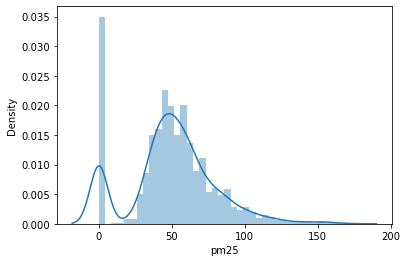

In [68]:
sns.distplot(air_quality['pm25'], bins=40)
plt.show()

- Even if we have some high values that look not compatible with the other columns of the table that are showing low levels of  pollutants at the same day; the right tail of the distribution actually makes some sense. By the other hand, the information that is not very well presenteted is the left side of the curve cointaining a lot of zero values, due to fillna with 0 instead of other parameter in the absence of the information.

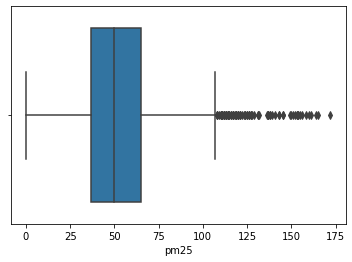

In [129]:
sns.boxplot(x='pm25', data=air_quality)
plt.show()

- The boxplot doesn't present the zeros from the sample as an outlier and shows all the high values as outliers what doesn't match with the histogram. Therefore, this date need more analysis.

In [72]:
air_quality[air_quality['pm10'] > 90] #90 is the cut for 'high' concentration of the pollutant

,pm25,pm10,o3,no2,co
date,,,,,
20141018,0.0,263.0,12.0,34.0,0.0
20201231,71.0,103.0,11.0,28.0,7.0


C:\Users\claud\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


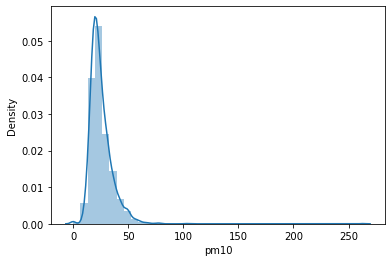

In [74]:
sns.distplot(air_quality['pm10'], bins=40)
plt.show()

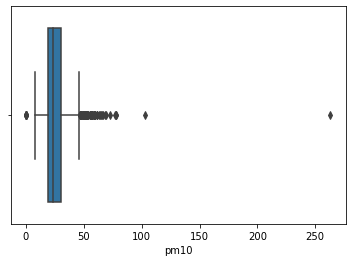

In [77]:
sns.boxplot(x='pm10', data=air_quality)
plt.show()

- Looking the plot of the data + boxplot we can see that the fill na with zeros doesn't represent the sample. It's also possible to see that the 2 values higher than 90 are not compatible and should be treated.

In [81]:
air_quality[air_quality['o3'] > 120] #120 is the cut for 'medium' concentration of the pollutant

,pm25,pm10,o3,no2,co
date,,,,,
20170406,61.0,31.0,205.0,24.0,2.0


C:\Users\claud\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


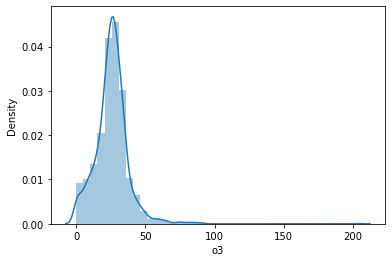

In [78]:
sns.distplot(air_quality['o3'], bins=40)
plt.show()

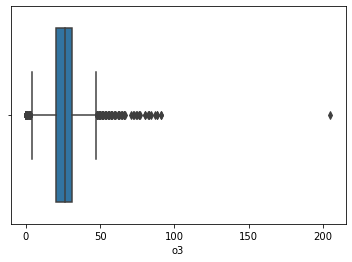

In [79]:
sns.boxplot(x='o3', data=air_quality)
plt.show()

- Looking the plot of the data +boxplot we can see that the fill na with zeros doesn't represent the sample. It's also possible to see that the unique value higher than 120 is not compatible and should be treated.

C:\Users\claud\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


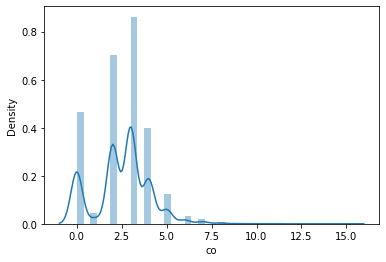

In [111]:
sns.distplot(air_quality['co'], bins=40)
plt.show()

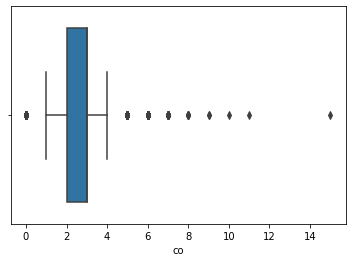

In [112]:
sns.boxplot(x='co', data=air_quality)
plt.show()

- The pollutant co shows some inconsistency as we can see a discrete distribution, many outliers, and a high number of missing values filled with zero. This low quality of the data id probably because this measure is not considered to calculate the index and, therefore, not openly availble to download and use.

- Let's calculate the quality of the air based on the Common Air Quality Index (CAQI) (air quality index used in Europe since 2006)

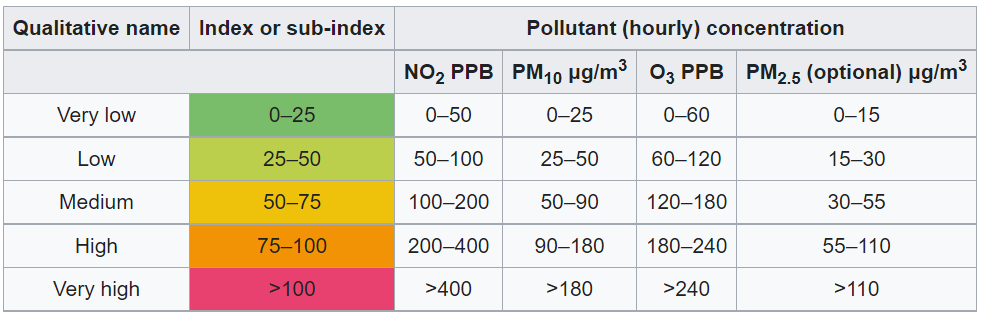

In [156]:
no2index = []
index = ''

for no2 in air_quality['no2']:
    
    if int(no2) == 0:
        index = 'zero'
    elif int(no2) < 50:
        index = 'very low'
    elif (int(no2) >= 50) & (int(no2) < 100):
        index = 'low'
    elif (int(no2) >= 100) & (int(no2) < 200):
        index = 'medium'        
    elif (int(no2) >= 200) & (int(no2) < 400):
        index = 'high'
    else: #elif no2 >= 400:
        index = 'very high'
    
    no2index.append(index)
    
air_quality['no2index'] = no2index

In [157]:
air_quality['no2index'].value_counts() # Imbalanced data identified

very low    2652
zero          12
low            2
Name: no2index, dtype: int64

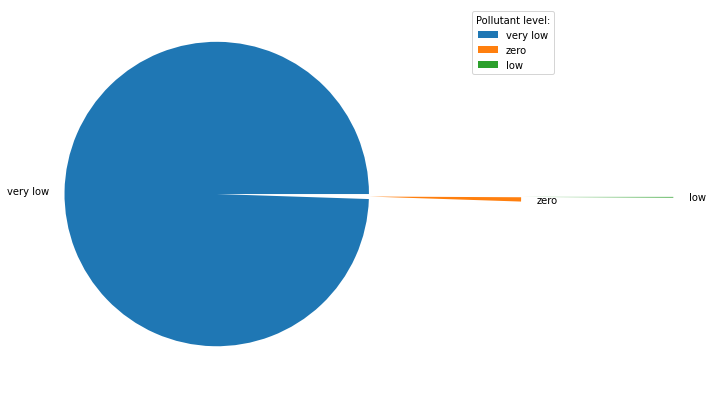

In [170]:
# Creating dataset
index = ['very low', 'zero', 'low'] #, 'medium', 'high', 'very high']
  
no2 = air_quality['no2index'].value_counts().tolist()

# Explode
myexplode = [1 , 0, 1]

# Formating
#mycolors = ["black", "hotpink", "b", "#4CAF50"]
  
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(no2, labels = index, explode = myexplode) # , shadow = True, colors = mycolors)
  
# show plot
plt.legend(title = "Pollutant level:")
plt.show()

- To find color options:

https://www.w3schools.com/colors/colors_hexadecimal.asp

https://www.w3schools.com/colors/colors_names.asp

In [159]:
pm10index = []
index = ''

for pm10 in air_quality['pm10']:
    
    if int(pm10) == 0:
        index = 'zero'
    elif int(pm10) < 25:
        index = 'very low'
    elif (int(pm10) >= 25) & (int(pm10) < 50):
        index = 'low'
    elif (int(pm10) >= 50) & (int(pm10) < 90):
        index = 'medium'        
    elif (int(pm10) >= 90) & (int(pm10) < 180):
        index = 'high'
    else: #elif pm10 >= 180:
        index = 'very high'
    
    pm10index.append(index)
    
air_quality['pm10index'] = pm10index

In [160]:
air_quality['pm10index'].value_counts()

very low     1531
low          1057
medium         67
zero            9
high            1
very high       1
Name: pm10index, dtype: int64

- Imbalanced data identified in the sense that we have only low and very low indexes populated, but between those levels the data presents itself in a quite well balanced way, as it's possible to see on the graph bellow

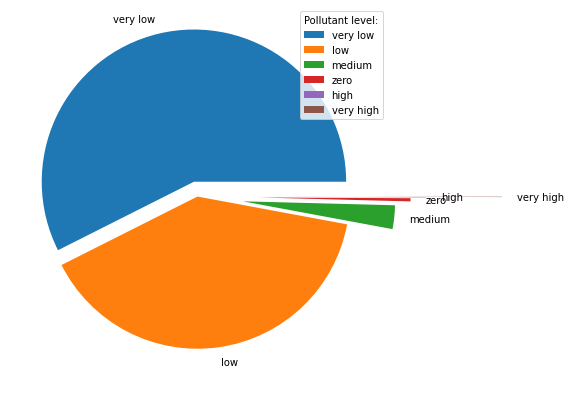

In [169]:
# Creating dataset
index = ['very low', 'low', 'medium', 'zero', 'high', 'very high']
  
pm10 = air_quality['pm10index'].value_counts().tolist()

# Explode
myexplode = [0.1, 0, 0.3, 0.4, 0.5, 1]

# Formating
#mycolors = ["black", "hotpink", "b", "#4CAF50"]
  
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(pm10, labels = index, explode = myexplode) # , shadow = True, colors = mycolors)
  
# show plot
plt.legend(title = "Pollutant level:")
plt.show()

In [175]:
o3index = []
index = ''

for o3 in air_quality['o3']:
    
    if int(o3) == 0:
        index = 'zero'
    elif int(o3) < 60:
        index = 'very low'
    elif (int(o3) >= 60) & (int(o3) < 120):
        index = 'low'
    elif (int(o3) >= 120) & (int(o3) < 200):
        index = 'medium'        
    elif (int(o3) >= 200) & (int(o3) < 400):
        index = 'high'
    else: #elif o3 >= 400:
        index = 'very high'
    
    o3index.append(index)
    
air_quality['o3index'] = o3index

In [176]:
air_quality['o3index'].value_counts() # Imbalanced data identified

very low    2580
zero          46
low           39
high           1
Name: o3index, dtype: int64

In [173]:
pm25index = []
index = ''

for pm25 in air_quality['pm25']:
    
    if int(pm25) == 0:
        index = 'zero'
    elif int(pm25) < 15:
        index = 'very low'
    elif (int(pm25) >= 15) & (int(pm25) < 30):
        index = 'low'
    elif (int(pm25) >= 30) & (int(pm25) < 55):
        index = 'medium'        
    elif (int(pm25) >= 55) & (int(pm25) < 110):
        index = 'high'
    else: #elif pm25 >= 110:
        index = 'very high'
    
    pm25index.append(index)
    
air_quality['pm25index'] = pm25index

In [181]:
air_quality['pm25index'].value_counts()

medium       1095
high         1022
zero          401
very high      85
low            62
very low        1
Name: pm25index, dtype: int64

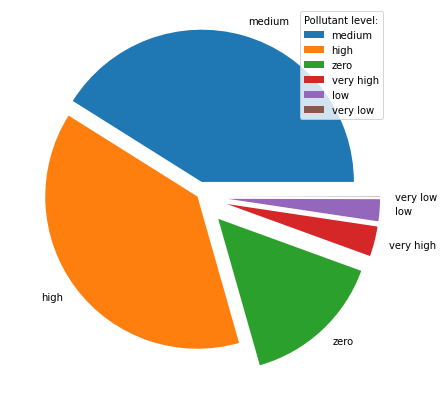

In [186]:
# Creating dataset
index = ['medium', 'high', 'zero', 'very high', 'low', 'very low']
  
pm25 = air_quality['pm25index'].value_counts().tolist()

# Explode
myexplode = [0.1, 0, 0.2, 0.2, 0.2, 0.2]

# Formating
#mycolors = ["black", "hotpink", "b", "#4CAF50"]
  
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(pm25, labels = index, explode = myexplode) # , shadow = True, colors = mycolors)
  
# show plot
plt.legend(title = "Pollutant level:")
plt.show()

- Checking for correlations

In [189]:
correlations_matrix = air_quality.corr()
correlations_matrix

,pm25,pm10,o3,no2,co
pm25,1.000000,0.319997,-0.064028,0.030471,0.476533
pm10,0.319997,1.000000,-0.051245,0.397521,0.223528
o3,-0.064028,-0.051245,1.000000,-0.048622,-0.063460
no2,0.030471,0.397521,-0.048622,1.000000,0.131282
co,0.476533,0.223528,-0.063460,0.131282,1.000000


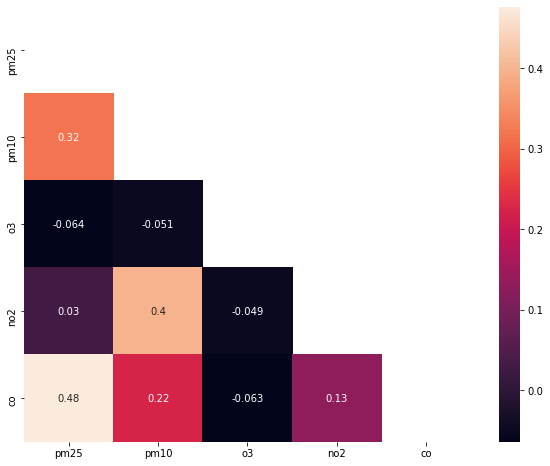

In [190]:
mask = np.zeros_like(correlations_matrix)

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)#change annot to False to hide the text, as it's unreadable
plt.show()

- Exporting this treated data

In [188]:
air_quality.head()

,pm25,pm10,o3,no2,co,no2index,pm10index,o3index,pm25index
date,,,,,,,,,
20131231,0.0,0.0,0.0,30.0,0.0,very low,zero,zero,zero
20140101,0.0,42.0,0.0,32.0,0.0,very low,low,zero,zero
20140102,0.0,14.0,0.0,28.0,0.0,very low,very low,zero,zero
20140103,0.0,17.0,0.0,26.0,0.0,very low,very low,zero,zero
20140104,0.0,19.0,0.0,28.0,0.0,very low,very low,zero,zero


In [206]:
air_quality.columns

Index(['pm25', 'pm10', 'o3', 'no2', 'co', 'no2index', 'pm10index', 'o3index',
       'pm25index'],
      dtype='object')

In [ ]:
air_quality2 = air_quality.copy()
air_quality2 = air_quality2[['pm25', 'pm10', 'o3', 'no2', 'co']]

In [ ]:
weather.to_csv('dutchweather.csv')
weather2.to_csv('dutchweather2.csv')

### Chi Square Test

In [201]:
crosstab = pd.crosstab(air_quality['no2index'],air_quality['pm25index'])

# chi square test
[statistic, p_value, dof, arr] = stats.chi2_contingency(crosstab)

# dof = observed.size - sum(observed.shape) + observed.ndim - 1
statistic, p_value, dof

(15.507499706693103, 0.11462554471525722, 10)

In [202]:
crosstab = pd.crosstab(air_quality['no2index'],air_quality['o3index'])

# chi square test
[statistic, p_value, dof, arr] = stats.chi2_contingency(crosstab)

# dof = observed.size - sum(observed.shape) + observed.ndim - 1
statistic, p_value, dof

(506.1523786763656, 3.974771210613758e-106, 6)

In [203]:
crosstab = pd.crosstab(air_quality['o3index'],air_quality['pm25index'])

# chi square test
[statistic, p_value, dof, arr] = stats.chi2_contingency(crosstab)

# dof = observed.size - sum(observed.shape) + observed.ndim - 1
statistic, p_value, dof

(102.62666171326411, 4.137642169543454e-15, 15)

In [204]:
crosstab = pd.crosstab(air_quality['o3index'],air_quality['pm10index'])

# chi square test
[statistic, p_value, dof, arr] = stats.chi2_contingency(crosstab)

# dof = observed.size - sum(observed.shape) + observed.ndim - 1
statistic, p_value, dof

(445.41941274034764, 1.9027390495502838e-85, 15)